**Корректность проверена на Python 3.6:**
+ numpy 1.15.4
+ matplotlib 3.0.2
+ pandas 0.23.4


# Практическое задание к уроку 1 (2 неделя).
## Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [2]:
# (0 баллов)
df = pd.read_csv('bikes_rent.csv')
df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

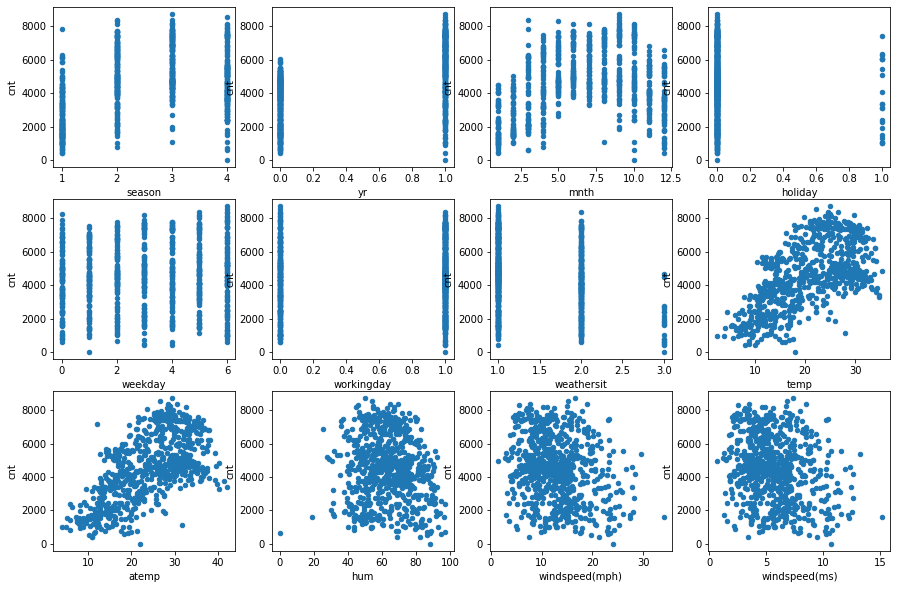

In [3]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

__Блок 1. Ответьте на вопросы (каждый 0.5 балла):__
1. Каков характер зависимости числа прокатов от месяца? 
   * ответ: как мне кажется зависимость имеет параболический вид.
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * ответ: линейной количество прокатов будет зависеть скорее всего от температуры или температуры по ощущениям.

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [4]:
# Код 1.1 (0.5 балла)
# Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:

# df.iloc[:, :-1] - срезка все признаки кроме последнего (cnt)
print('Корреляция признака cnt со всеми остальными признаками:')
df.iloc[:, :-1].corrwith(df['cnt'])

# Вариант
# corr = pd.DataFrame(df.drop('cnt', axis = 1).corrwith(df['cnt']))
# corr.columns = ['corr']
# corr.sort_values('corr')

Корреляция признака cnt со всеми остальными признаками:


season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [5]:
# Код 1.2 (0.5 балла)
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:
df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [6]:
# Код 1.3 (0.5 балла)
# Выведите средние признаков
pd.DataFrame(df.mean(), columns=['Mean'])

,Mean
season,2.496580
yr,0.500684
mnth,6.519836
holiday,0.028728
weekday,2.997264
workingday,0.683995
weathersit,1.395349
temp,20.310776
atemp,23.717699
hum,62.789406


Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделаВь с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [7]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [8]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
# Код 2.1 (1 балл)
# Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели 
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python
# Названия признаков хранятся в переменной df.columns
lienar_regression = LinearRegression()
lienar_regression.fit(X, y)
pd.DataFrame(list(zip(df.columns, lienar_regression.coef_)), columns=['Признак', 'Linear Regression'])

,Признак,Linear Regression
0,season,5.708706e+02
1,yr,1.021964e+03
2,mnth,-1.413018e+02
3,holiday,-8.676021e+01
4,weekday,1.372258e+02
5,workingday,5.639048e+01
6,weathersit,-3.302290e+02
7,temp,3.674638e+02
8,atemp,5.855667e+02
9,hum,-1.456121e+02


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_, вы обсуждали ее на лекции.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge. Подробнее об этом также рассказано в лекции.

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [11]:
from sklearn.linear_model import Lasso, Ridge

In [12]:
# Код 2.2 (0.5 балла)
# Обучите линейную модель с L1-регуляризацией и выведите веса
lasso_regression = Lasso()
lasso_regression.fit(X, y)
comparison_methods = list(zip(df.columns, lasso_regression.coef_, lienar_regression.coef_))
pd.DataFrame(comparison_methods, columns=['Признак', 'Lasso', 'Linear Regression'])

,Признак,Lasso,Linear Regression
0,season,5.602416e+02,5.708706e+02
1,yr,1.019463e+03,1.021964e+03
2,mnth,-1.287306e+02,-1.413018e+02
3,holiday,-8.615278e+01,-8.676021e+01
4,weekday,1.373479e+02,1.372258e+02
5,workingday,5.521237e+01,5.639048e+01
6,weathersit,-3.323699e+02,-3.302290e+02
7,temp,3.763632e+02,3.674638e+02
8,atemp,5.765308e+02,5.855667e+02
9,hum,-1.441292e+02,-1.456121e+02


In [13]:
# Код 2.3 (0.5 балла)
# Обучите линейную модель с L2-регуляризацией и выведите веса
ridge_regression = Ridge()
ridge_regression.fit(X, y)
comparison_methods = list(zip(df.columns, ridge_regression.coef_, lienar_regression.coef_))
pd.DataFrame(comparison_methods, columns=['Признак', 'Ridge', 'Linear Regression'])

,Признак,Ridge,Linear Regression
0,season,563.064572,5.708706e+02
1,yr,1018.948379,1.021964e+03
2,mnth,-131.873320,-1.413018e+02
3,holiday,-86.746098,-8.676021e+01
4,weekday,138.005111,1.372258e+02
5,workingday,55.903110,5.639048e+01
6,weathersit,-332.349788,-3.302290e+02
7,temp,386.457889,3.674638e+02
8,atemp,566.347047,5.855667e+02
9,hum,-145.071327,-1.456121e+02


### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение данному факту дается в одной из лекций курса.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [14]:
# Код 3.1 (1 балл)

alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso (вспомните встроенную в python функцию enumerate),
# а затем обучите Ridge и запишите веса в coefs_ridge.

for i, val in enumerate(alphas):
    lasso_regression = Lasso(val)
    ridge_regression = Ridge(val)
    
    lasso_regression.fit(X, y)
    ridge_regression.fit(X, y)
    
    coefs_lasso[i] = lasso_regression.coef_
    coefs_ridge[i] = ridge_regression.coef_

Визуализируем динамику весов при увеличении параметра регуляризации:

array([  1,  51, 101, 151, 201, 251, 301, 351, 401, 451])

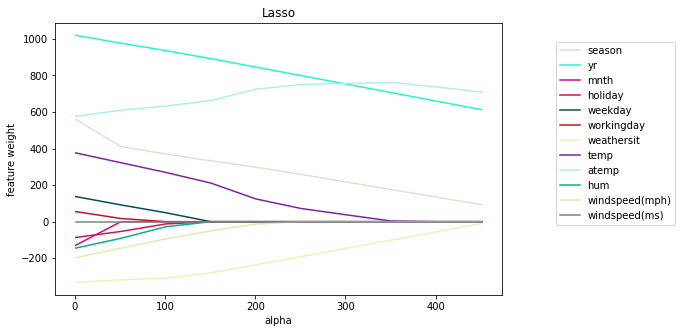

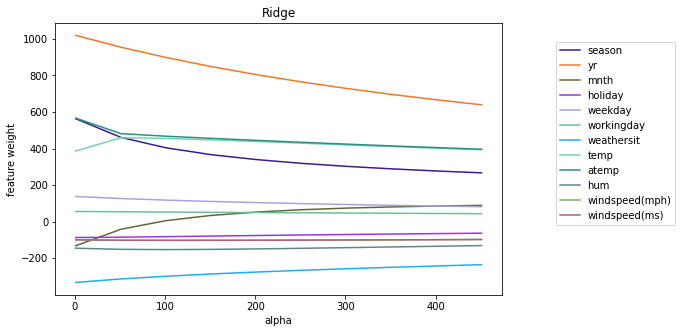

In [15]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")
alphas

Ответы на следующие вопросы можно давать, глядя на графики или выводя коэффициенты на печать.

__Блок 2. Ответьте на вопросы (каждый 0.25 балла)__:
1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
    * Ответ: Регулязатор Lasso
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * Ответ: Если увеличить коэффициент регуляризации в методе Lasso, то таким образом увеличивает ограничение на величину суммы модулей весов в линейной модели и таком обрзом больше зануляются незначимые для модели коэффициенты.
1. Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha > 0? А Ridge? Ситается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.
    * Ответ: Да, windspeed выраженная в ms ислюкчается, даже при aplpha = 1e-7. Метод Ridge не исключает признак windspeed(ms).
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
    * Ответ: Регуляризатор Lasso подойдет для этой цели.

In [16]:
alpha_series = pd.Series(alphas)

df_lasso = pd.DataFrame(coefs_lasso, columns=df.columns[:-1])
df_lasso.insert(0, 'alpha', alpha_series)
df_lasso

,alpha,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
0,1,560.241616,1019.463494,-128.730627,-86.152781,137.347894,55.212371,-332.369857,376.363236,576.530794,-144.129155,-197.139689,-2.803860e-08
1,51,410.969632,977.019409,-0.000000,-53.448969,91.943437,17.537212,-318.125568,322.829934,610.031512,-91.068962,-145.066095,-2.297881e-08
2,101,370.077089,935.945490,0.000000,-12.161936,48.888634,0.000000,-308.805664,269.417263,632.502623,-27.504288,-93.774904,-2.415847e-08
3,151,332.835717,891.870058,0.000000,-0.000000,0.000000,0.000000,-279.616688,211.052030,662.920880,-0.000000,-50.155147,-2.627248e-08
4,201,298.134448,845.652857,0.000000,-0.000000,0.000000,0.000000,-235.571345,124.144807,725.379483,-0.000000,-12.646177,-2.787566e-08
5,251,258.927201,799.237273,0.000000,-0.000000,0.000000,0.000000,-190.821549,72.075938,750.363107,-0.000000,-0.000000,-0.000000e+00
6,301,217.427513,752.720808,0.000000,-0.000000,0.000000,0.000000,-145.713398,37.715365,756.296866,-0.000000,-0.000000,-0.000000e+00
7,351,175.929845,706.203788,0.000000,-0.000000,0.000000,0.000000,-100.605389,3.660938,761.926337,-0.000000,-0.000000,-0.000000e+00
8,401,134.628497,659.632535,0.000000,-0.000000,0.000000,0.000000,-55.511063,0.000000,737.348061,-0.000000,-0.000000,-0.000000e+00
9,451,93.351742,613.054639,0.000000,-0.000000,0.000000,0.000000,-10.418569,0.000000,709.130877,-0.000000,-0.000000,-0.000000e+00


In [17]:
df_ridge = pd.DataFrame(coefs_ridge, columns=df.columns[:-1])
df_ridge.insert(0, 'alpha', alpha_series)
df_ridge

,alpha,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
0,1,563.064572,1018.948379,-131.873320,-86.746098,138.005111,55.903110,-332.349788,386.457889,566.347047,-145.071327,-99.259441,-99.259441
1,51,461.178632,954.307742,-41.565450,-84.913470,126.603667,54.251691,-313.275151,458.901477,481.443500,-151.291010,-101.627315,-101.627315
2,101,403.976530,898.083622,5.674243,-81.911062,117.941411,52.728484,-298.408981,455.289868,467.431417,-152.686051,-102.101671,-102.101671
3,151,366.604239,848.463465,34.027283,-78.771965,110.680120,51.257192,-286.125159,447.479825,455.754030,-151.483206,-102.005376,-102.005376
4,201,339.745290,804.251048,52.489873,-75.717408,104.403464,49.841895,-275.486095,438.509689,444.764274,-148.943970,-101.586385,-101.586385
5,251,319.158641,764.561434,65.152007,-72.819708,98.878804,48.484525,-266.002556,429.214123,434.235235,-145.698115,-100.964711,-100.964711
6,301,302.636060,728.708540,74.138281,-70.098983,93.955811,47.185338,-257.390629,419.926152,424.121922,-142.089345,-100.208620,-100.208620
7,351,288.913276,696.145816,80.660457,-67.554852,89.528675,45.943467,-249.471395,410.800184,414.409373,-138.316538,-99.360661,-99.360661
8,401,277.213216,666.429747,85.459254,-65.178706,85.518667,44.757303,-242.124399,401.911945,405.085853,-134.499038,-98.449064,-98.449064
9,451,267.031090,639.195368,89.012323,-62.958906,81.864909,43.624770,-235.263997,393.297986,396.138155,-130.709872,-97.493434,-97.493434


In [18]:
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1]))

alphas_small = np.geomspace(10e-7, 0.1, 6)

coeff_lasso_small = np.zeros((alphas_small.shape[0], X.shape[1]))
coeff_ridge_small = np.zeros((alphas_small.shape[0], X.shape[1]))

for i, val in enumerate(alphas_small):
    lasso_regression_small_alpha = Lasso(val)
    ridge_regression_small_alpha = Ridge(val)
    lasso_regression_small_alpha.fit(X, y)
    ridge_regression_small_alpha.fit(X, y)
    coeff_lasso_small[i] = lasso_regression_small_alpha.coef_
    coeff_ridge_small[i] = ridge_regression_small_alpha.coef_

    
#подготовка таблиц
sereis_alphas = pd.Series(alphas_small)

df_coeff_lasso_small = pd.DataFrame(coeff_lasso_small, columns=df.columns[:-1])
df_coeff_lasso_small.insert(0, 'alphas', sereis_alphas)

df_ceoff_ridge_small = pd.DataFrame(coeff_ridge_small, columns=df.columns[:-1])
df_ceoff_ridge_small.insert(0, 'alphas', sereis_alphas)

df_coeff_lasso_small

,alphas,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
0,0.000001,565.874448,1020.350745,-134.461985,-86.692605,138.360291,55.955776,-332.695568,371.141123,581.906431,-145.016237,-198.070546,-9.641796e-08
1,0.000010,565.874399,1020.350736,-134.461935,-86.692605,138.360274,55.955767,-332.695572,371.142264,581.905290,-145.016219,-198.070562,-8.193090e-08
2,0.000100,565.873913,1020.350645,-134.461431,-86.692612,138.360107,55.955679,-332.695605,371.153769,581.893788,-145.016030,-198.070726,-6.739632e-08
3,0.001000,565.869043,1020.349733,-134.456390,-86.692674,138.358447,55.954798,-332.695934,371.267474,581.780116,-145.014156,-198.072336,-5.292739e-08
4,0.010000,565.820368,1020.340608,-134.405993,-86.693335,138.341781,55.945973,-332.699274,372.413414,580.634509,-144.995331,-198.088637,-3.836298e-08
5,0.100000,565.321657,1020.256102,-133.895006,-86.667279,138.219834,55.870357,-332.695555,377.368324,575.672782,-144.871247,-198.105578,-2.827367e-08


In [19]:
df_ceoff_ridge_small

,alphas,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
0,0.000001,565.874451,1020.350745,-134.461988,-86.692605,138.360292,55.955777,-332.695568,371.141013,581.906541,-145.016239,-98.998845,-99.071700
1,0.000010,565.874425,1020.350732,-134.461965,-86.692605,138.360289,55.955776,-332.695565,371.141174,581.906376,-145.016240,-99.031630,-99.038919
2,0.000100,565.874172,1020.350606,-134.461731,-86.692611,138.360255,55.955771,-332.695535,371.142793,581.904734,-145.016242,-99.034933,-99.035662
3,0.001000,565.871636,1020.349340,-134.459388,-86.692672,138.359919,55.955720,-332.695243,371.158981,581.888312,-145.016264,-99.035491,-99.035564
4,0.010000,565.846283,1020.336689,-134.435959,-86.693280,138.356556,55.955212,-332.692311,371.320573,581.724372,-145.016488,-99.037818,-99.037825
5,0.100000,565.592796,1020.210205,-134.201794,-86.699216,138.323120,55.950172,-332.662787,372.909081,580.112585,-145.019047,-99.060446,-99.060446


Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (установить параметр cv=3) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [20]:
from sklearn.linear_model import LassoCV

Выбранное alpha = 6. 


array([[863936.50981215, 826364.11936907, 862993.29751896],
       [860479.31511364, 821110.1817776 , 853075.13780625],
       [857344.83606082, 816153.27782428, 843628.81286098],
       [854526.73639431, 811496.34805693, 834654.45357262],
       [852024.62341384, 807139.39657173, 826152.16399015],
       [849838.18755425, 803082.42338526, 818122.01934906],
       [847967.16232762, 799325.42849761, 810564.07404745],
       [846411.31812808, 795868.41190876, 803478.36741509],
       [845170.45707972, 792711.37361871, 796864.92788593],
       [844244.40861679, 789854.31362747, 790723.77601555],
       [843633.02568868, 787297.23193504, 785058.69560905],
       [843336.18149882, 785040.12854141, 779861.12465128],
       [843353.76670095, 783083.00344659, 775139.9023601 ],
       [843616.44582031, 781425.85665058, 770886.43550572],
       [843608.19759457, 780068.68815337, 767109.44006007],
       [844145.56423514, 777586.36117475, 763800.36416062],
       [845219.34650306, 775290.91645251

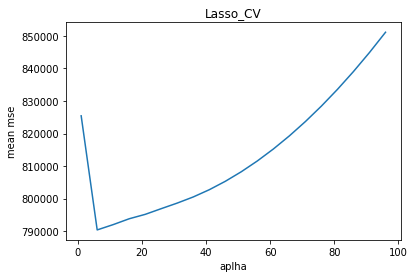

In [21]:
# Код 3.2 (1 балл)
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha. 
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1, 100, 5)
lasso_cv = LassoCV(cv = 3, alphas=alphas)
lasso_cv.fit(X,y)

mse_mean = np.array([i.mean() for i in lasso_cv.mse_path_])

plt.plot(lasso_cv.alphas_, mse_mean)
plt.xlabel('aplha')
plt.ylabel('mean mse')
plt.title('Lasso_CV')

print('Выбранное alpha = {}. '.format(lasso_cv.alpha_))

mse_alpha = list(zip(df.columns[:-1], lasso_cv.coef_))    
pd.DataFrame(mse_alpha, columns=['Признак', 'Коэффициент'])
lasso_cv.mse_path_

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

cv = 1, alpha = 41
cv = 2, alpha = 6
cv = 3, alpha = 1


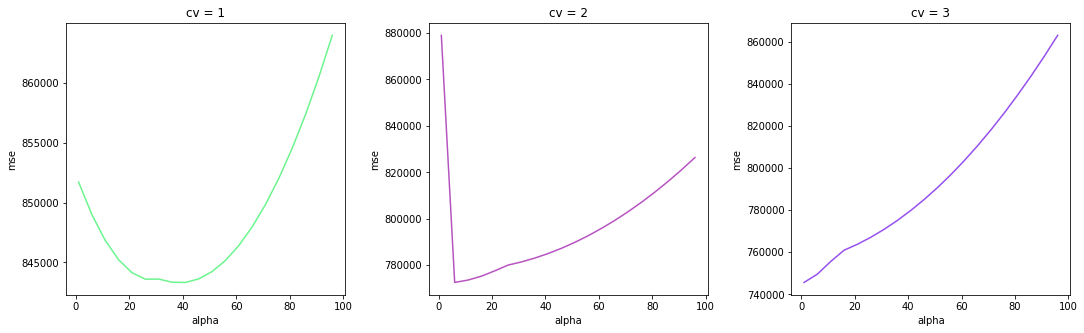

In [22]:
# Код 3.3 (1 балл)
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируйте столбцы .mse_path_

for ind, mse in enumerate(lasso_cv.mse_path_.T):
    index_min = np.argmin(mse)
    print('cv = {0}, alpha = {1}'.format(ind+1, lasso_cv.alphas_[index_min]))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

fig.subplots_adjust(wspace=0.3)

for ind, val in enumerate(lasso_cv.mse_path_.T):
    axp = ax[ind]
    axp.plot(lasso_cv.alphas_, val, color = np.random.rand(3))
    axp.set_xlabel('alpha')
    axp.set_ylabel('mse')
    axp.set_title('cv = {0}'.format(ind+1))

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

__Блок 3. Ответьте на вопросы (каждый 0.5 балла):__
1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    * Ответ: Линейная зависимость cnt от признаков yr, atemp, temp есть. Однако между cnt и season скорее всего параболическая зависимость, но все равно эту зависимость можно аппроксимировать линейно. Однако сложно утвержадть, что чем больше год, то будет расти параметр cnt, также как слжоно утверждать, что если больше season (4 - зима), то количество прокатов будет больше, потому что зимой люди вряд ли будут кататься на велосипедах.

Коэффициенты модели - 4 максимальных коэффициента:


,Lasso koef
yr,1015.060223
atemp,581.396931
season,532.018983
temp,370.679855


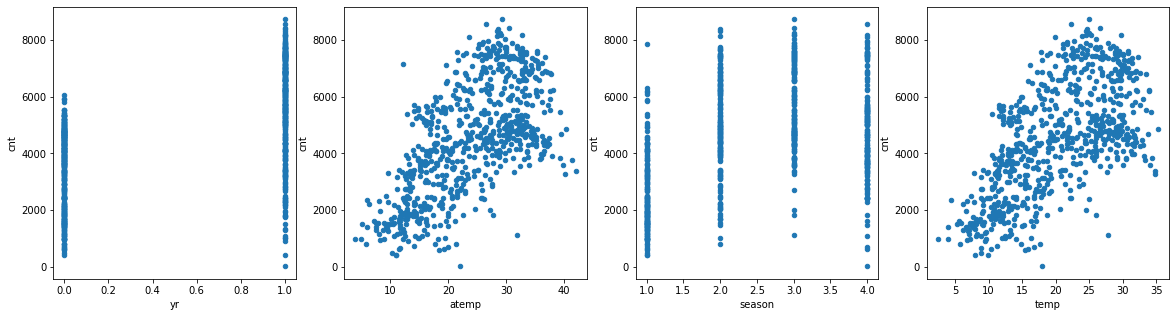

In [23]:
n_param = 4
print('Коэффициенты модели - {0} максимальных коэффициента:'.format(n_param))
# Получаем индексы 4 максимальных элементов
indexes = np.argsort(lasso_cv.coef_)[-n_param:][::-1]
# Добавляем индекс cnt
indexes_all = np.append(indexes, [len(df.columns)-1])
    
df_indexes = df.iloc[:, indexes_all]
fig, axes = plt.subplots(nrows=1, ncols=n_param, figsize=(20, 5))
for ind, feature in enumerate(df_indexes.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[ind])
    
pd.DataFrame(lasso_cv.coef_[indexes], index=df.columns[indexes], columns=['Lasso koef'])

1. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
    * Ответ: Имеется убвыающая линейная звисимость признака ctn от weathersit, windspeed(mph), hum. По своеме смыслу эти параметры описывают погоду и чем выше значение дынных параметров тем хуже погода для катания на велосипеде. Так что можно сказать, что чем выше значение этих признаков тем меньше людей захотят взять велосипеда. 

Коэффициенты модели - 3 минимальных коэффициента:


,Lasso koef
weathersit,-330.559857
windspeed(mph),-191.771408
hum,-140.007406


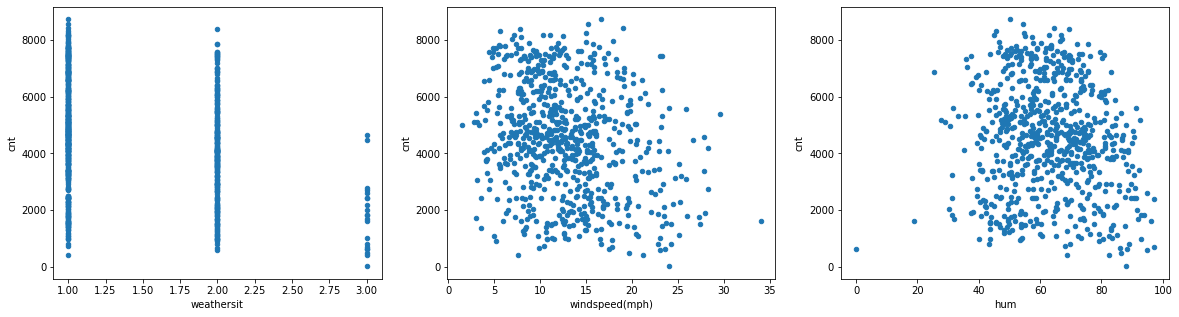

In [24]:
n_param = 3
print('Коэффициенты модели - {0} минимальных коэффициента:'.format(n_param))
# Получаем индексы 3 минимальных элементов
indexes = np.argsort(lasso_cv.coef_)[:n_param]
# Добавляем индекс cnt
indexes_all = np.append(indexes, [len(df.columns)-1])

df_indexes = df.iloc[:, indexes_all]
fig, axes = plt.subplots(nrows=1, ncols=n_param, figsize=(20, 5))
for ind, feature in enumerate(df_indexes.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[ind])
    
pd.DataFrame(lasso_cv.coef_[indexes], index=df.columns[indexes], columns=['Lasso koef'])

1. Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    * Ответ: Коэффиципент при параметре windspeed(ms) в моделе близкий к нулю, т.е. модель исключает зависимость от этого параметра. Алогоритм Lasso исключает данный параметр из модели потому, он коррелирует с windpseed(mph). Это, видимо, связано с особеннотью мультиколлинеарности в данном наборе данных, что логичным потому что один и тот же параметр - скорость, просто выражен в разных единицах.

Коэффициенты модели - близкие к нулю:


,Lasso koef
windspeed(ms),-2.684357e-08


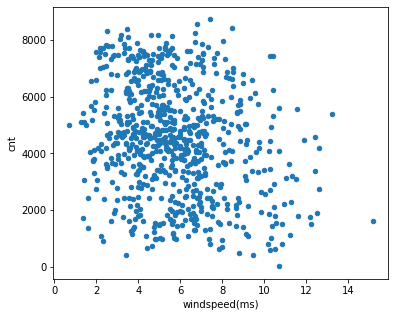

In [25]:
th = 1e-3 # пороговое значение

abs_coef_ = np.abs(lasso_cv.coef_) # получаем абсолютные значыения
func_map = lambda x: x[0]
func_filter = lambda x: x[1] < th
# получаем индексы элементов значение которых меньше th
indexes = list(map(func_map, filter(func_filter, enumerate(abs_coef_))))
# Добавляем индекс cnt
indexes_all = np.append(indexes, [len(df.columns)-1])

n_param = len(indexes)
print('Коэффициенты модели - близкие к нулю:')

df_filter = df.iloc[:, indexes_all]
fig, axes = plt.subplots(nrows=1, ncols=n_param, figsize=(6, 5))
for ind, feature in enumerate(df_filter.columns[:-1]):
    if (n_param==1):
        df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes)
    else:
        df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[ind])

pd.DataFrame(lasso_cv.coef_[indexes], index=df.columns[indexes], columns=['Lasso koef'])        

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.